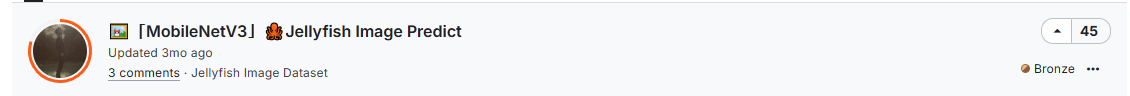

In [20]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow import keras 
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast


In [21]:
#Create Files_Name
image_data=r'D:\code_study\ML_CODE\dataSets\Jellyfish_Image_Dataset\archive\Train_Test_Valid\Train'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])


,Files_Name
0,barrel_jellyfish
1,blue_jellyfish
2,compass_jellyfish
3,lions_mane_jellyfish
4,mauve_stinger_jellyfish
5,Moon_jellyfish


In [22]:
#Create Files_Name
image_valid_data=r'D:\code_study\ML_CODE\dataSets\Jellyfish_Image_Dataset\archive\Train_Test_Valid\valid'
pd.DataFrame(os.listdir(image_valid_data),columns=['Files_Name'])

,Files_Name
0,barrel_jellyfish
1,blue_jellyfish
2,compass_jellyfish
3,lions_mane_jellyfish
4,mauve_stinger_jellyfish
5,Moon_jellyfish


In [23]:
# Define a function to create the dataframe
def create_dataframe(image_folder):
    files = glob.glob(os.path.join(image_folder, '**', '*.*'), recursive=True)  # Search for all files recursively
    np.random.shuffle(files)  # Shuffle the files
    labels = [os.path.basename(os.path.dirname(f)) for f in files]  # Extract labels from folder names
    return pd.DataFrame({'Image': files, 'Label': labels})

# Create train and validation dataframes
dataframe_train = create_dataframe(image_data)
dataframe_valid = create_dataframe(image_valid_data)

Dataset                   Training  Validation
Label                                         
Moon_jellyfish           16.666667   15.384615
barrel_jellyfish         16.666667   12.820513
blue_jellyfish           16.666667   17.948718
compass_jellyfish        16.666667   17.948718
lions_mane_jellyfish     16.666667   17.948718
mauve_stinger_jellyfish  16.666667   17.948718


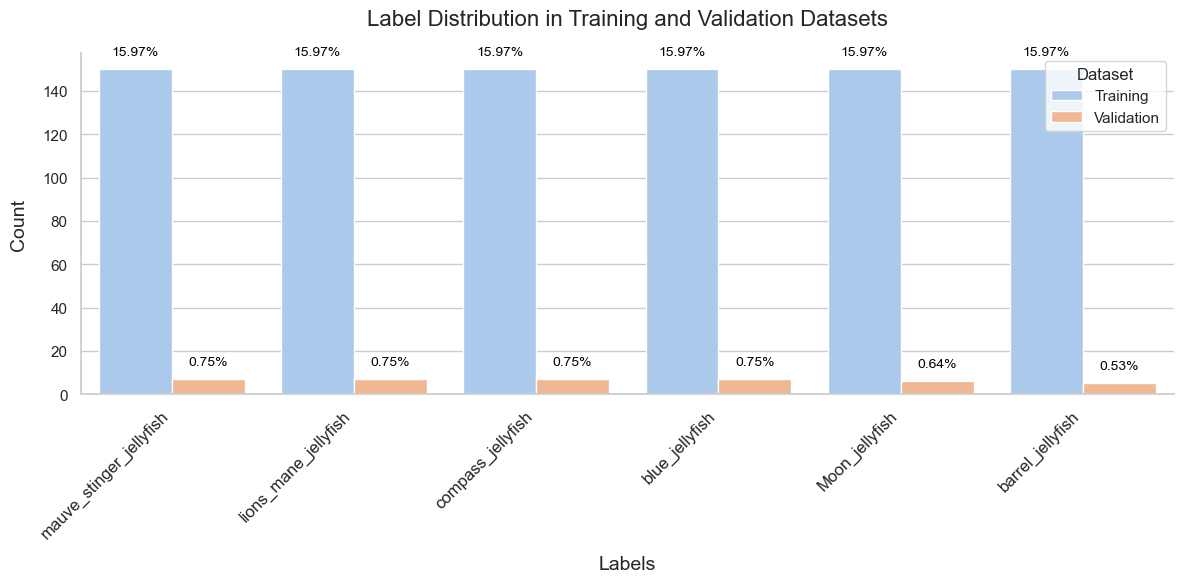

In [24]:
# Add a column to differentiate between train and validation datasets
dataframe_train['Dataset'] = 'Training'
dataframe_valid['Dataset'] = 'Validation'

# Combine the two dataframes
combined_df = pd.concat([dataframe_train, dataframe_valid], ignore_index=True)

# Set a theme for better aesthetics
sns.set_theme(style="whitegrid")

# Calculate counts and percentages for each label in each dataset
count_data = combined_df.groupby(['Label', 'Dataset']).size().unstack(fill_value=0)
percentage_data = count_data.div(count_data.sum(axis=0), axis=1) * 100

# Print the percentage data (optional)
print(percentage_data)

# Create a color palette for the bars
palette = sns.color_palette("pastel", len(count_data))

# Plot the count plot for both training and validation sets
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x="Label", hue="Dataset", order=count_data.sum(axis=1).sort_values(ascending=False).index, palette="pastel")

# Annotate each bar with the percentage value
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar
    percentage = f'{(height / len(combined_df)) * 100:.2f}%'  # Calculate percentage
    ax.annotate(percentage,  # The label to be annotated
                (p.get_x() + p.get_width() / 2., height),  # Position of the label
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

# Rotate x-axis labels for better visibility and set the label font size
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add title and labels with improved fonts and padding
plt.title("Label Distribution in Training and Validation Datasets", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [25]:
batch_size = 64
target_size = (224,224)
train= tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    image_valid_data,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.


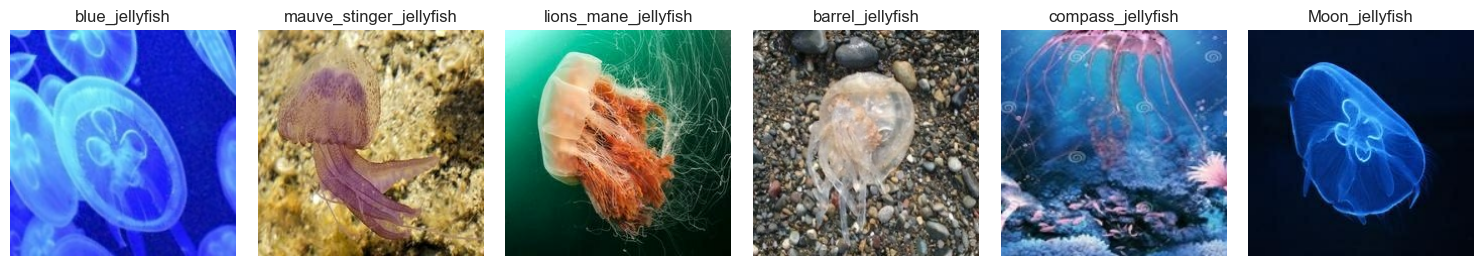

In [26]:
# Get the class names from the training dataset
class_labels = train.class_names

# Set up the figure size for displaying images (adjusted for the number of classes)
plt.figure(figsize=(15, 10))

# Track the classes already shown
shown_classes = set()

# Take one batch from the train dataset
for images, labels in train.take(1):
    for i in range(len(images)):  # Loop through the batch
        class_name = class_labels[labels[i]]
        if class_name not in shown_classes:
            # Plot the image only if its class has not been shown yet
            ax = plt.subplot(1, 6, len(shown_classes) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            shown_classes.add(class_name)
        
        # Stop once all classes have been displayed
        if len(shown_classes) == len(class_labels):
            break

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [27]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3),include_top=False,weights='imagenet')
#weights_path = './resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5'

# 加载本地权重文件
#base_model.load_weights(weights_path)
# Freeze the base model layers to prevent them from being trained
base_model.trainable = True  #Unfreeze Some Layers for Fine-Tuning
fine_tune_at = len(base_model.layers) - 20  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create  model
keras_model = keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.GlobalAveragePooling2D())  
keras_model.add(keras.layers.BatchNormalization())  
keras_model.add(keras.layers.Dense(128, activation='relu'))  
keras_model.add(keras.layers.Dropout(0.5))  
keras_model.add(keras.layers.Dense(6, activation=tf.nn.softmax))  # 6 output units for classification

# Display the model's architecture
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 4,396,294
Trainable params: 1,938,182
Non-trainable params: 2,458,112
____________________________________

In [28]:
#tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [29]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [30]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [31]:
# Apply data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
])

train = train.map(lambda x, y: (data_augmentation(x, training=True), y))  # Apply augmentation only during training


# Modify the Adam optimizer with a lower learning rate and adjusted betas
custom_adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

keras_model.compile(optimizer =custom_adam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=80,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/80
15/15 [==============================] - 7s 309ms/step - loss: 2.5527 - accuracy: 0.2436 - val_loss: 1.7704 - val_accuracy: 0.3590
Epoch 2/80
15/15 [==============================] - 5s 280ms/step - loss: 1.2113 - accuracy: 0.5696 - val_loss: 1.5275 - val_accuracy: 0.4359
Epoch 3/80
15/15 [==============================] - 5s 282ms/step - loss: 0.7252 - accuracy: 0.7328 - val_loss: 1.3435 - val_accuracy: 0.5128
Epoch 4/80
15/15 [==============================] - 5s 281ms/step - loss: 0.6233 - accuracy: 0.7670 - val_loss: 1.1428 - val_accuracy: 0.6154
Epoch 5/80
15/15 [==============================] - 5s 285ms/step - loss: 0.4492 - accuracy: 0.8336 - val_loss: 1.0250 - val_accuracy: 0.6154
Epoch 6/80
15/15 [==============================] - 5s 283ms/step - loss: 0.4186 - accuracy: 0.8510 - val_loss: 0.9246 - val_accuracy: 0.6667
Epoch 7/80
15/15 [==============================] - 5s 285ms/step - loss: 0.3026 - accuracy: 0.9024 - val_loss: 0.8748 - val_accuracy: 0.6923
Epoch 

In [32]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,2.203223,0.294444,1.770386,0.358974
1,1.119390,0.607778,1.527522,0.435897
2,0.728673,0.740000,1.343532,0.512821
3,0.605462,0.776667,1.142781,0.615385
4,0.452964,0.836667,1.025021,0.615385
5,0.401620,0.856667,0.924562,0.666667
6,0.318951,0.892222,0.874752,0.692308
7,0.310795,0.903333,0.829495,0.717949
8,0.255907,0.917778,0.815593,0.717949
9,0.250050,0.917778,0.796452,0.717949


In [33]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

1/1 [==============================] - 0s 87ms/step - loss: 0.7561 - accuracy: 0.6923
Test Loss = 0.7560916543006897
Test Accuracy = 0.692307710647583


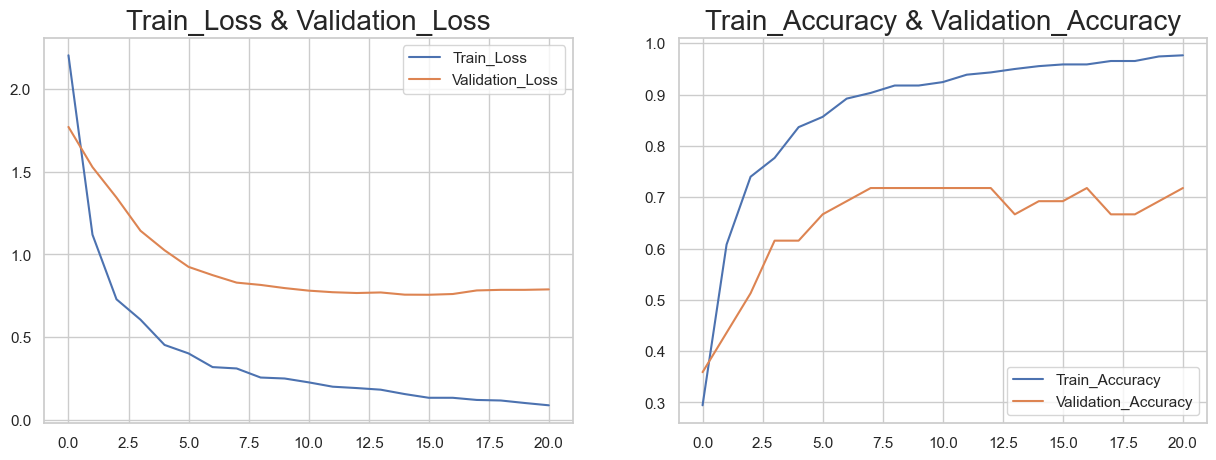

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [35]:
image_test_data=r'D:\code_study\ML_CODE\dataSets\Jellyfish_Image_Dataset\archive\Train_Test_Valid\test'
pd.DataFrame(os.listdir(image_test_data),columns=['Files_Name'])

,Files_Name
0,barrel_jellyfish
1,blue_jellyfish
2,compass_jellyfish
3,lions_mane_jellyfish
4,mauve_stinger_jellyfish
5,Moon_jellyfish


In [36]:
test= tf.keras.preprocessing.image_dataset_from_directory(
    image_test_data,
    image_size=(224,224),
    validation_split=None,
)

Found 40 files belonging to 6 classes.


In [37]:
test_score, test_acc = keras_model.evaluate(test)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

2/2 [==============================] - 0s 17ms/step - loss: 0.5613 - accuracy: 0.8750
Test Loss = 0.5613487958908081
Test Accuracy = 0.875


In [38]:
Accuracy = [('valid', score, acc),
          ('test', test_score, test_acc)
         ]                                                 

predict_test = pd.DataFrame(data = Accuracy, columns=['Model', 'loss', 'accuracy'])
predict_test

,Model,loss,accuracy
0,valid,0.756092,0.692308
1,test,0.561349,0.875000
